In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

from helper_functions import euclidean_distance
from helper_functions import contrastive_loss
from helper_functions import load_arrays
from helper_functions import plot_training
from helper_functions import load_and_split_data
from helper_functions import plot_confusion_matrix
from helper_functions import get_model_predictions
from helper_functions import plot_roc_curve
from helper_functions import plot_prec_rec_curve

# Load and prepare Data

### Load and create fast input pipeline with tf.data.dataset

In [41]:
%%time
train_dataset, test_dataset, val_dataset = load_and_split_data("npz_datasets/data_x_10000_rgb.npz", "npz_datasets/data_y_10000_rgb.npz", split_size=80, batch_size=256)

CPU times: user 36.4 s, sys: 8.18 s, total: 44.6 s
Wall time: 44.5 s


# Baseline Model

In [42]:
img_width = 224
img_height = 224

In [43]:
#Set seed
tf.random.set_seed(42)

#Build the model
inputs = keras.layers.Input((img_width, img_height, 3))

x = keras.layers.Conv2D(4, (3,3), activation="relu")(inputs)
x = keras.layers.MaxPool2D(3,3)(x)
x = keras.layers.Conv2D(16, (3,3), activation="relu")(x)
x = keras.layers.MaxPool2D(3,3)(x)
x = keras.layers.Conv2D(32, (3,3), activation="relu")(x)
x = keras.layers.MaxPool2D(3,3)(x)

x = keras.layers.Flatten()(x)

outputs = keras.layers.Dense(48, activation="relu")(x)

base_model_1 = keras.models.Model(inputs, outputs)

In [44]:
base_model_1.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 4)       112       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 16)        592       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0   

In [45]:
#define inputs and ouputs
img_a = keras.layers.Input((img_width, img_height, 3))
img_b = keras.layers.Input((img_width, img_height, 3))

feat_vect_a = base_model_1(img_a)
feat_vect_b = base_model_1(img_b)

distance = keras.layers.Lambda(euclidean_distance)([feat_vect_a, feat_vect_b])

In [46]:
#Compile the model 
model_1 = keras.models.Model(inputs=[img_a, img_b], outputs=distance)
model_1.compile(loss=contrastive_loss, optimizer="Adam", metrics=["accuracy"])

In [47]:
epochs=10
history_model_1 = model_1.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

Epoch 1/10
32/32 [==============================] - 19s 557ms/step - loss: 0.2837 - accuracy: 0.4908 - val_loss: 0.2663 - val_accuracy: 0.4881
Epoch 2/10
32/32 [==============================] - 17s 548ms/step - loss: 0.2593 - accuracy: 0.5171 - val_loss: 0.2648 - val_accuracy: 0.4900
Epoch 3/10
32/32 [==============================] - 17s 547ms/step - loss: 0.2507 - accuracy: 0.5505 - val_loss: 0.2644 - val_accuracy: 0.4881
Epoch 4/10
32/32 [==============================] - 17s 548ms/step - loss: 0.2446 - accuracy: 0.5688 - val_loss: 0.2653 - val_accuracy: 0.4938
Epoch 5/10
32/32 [==============================] - 18s 550ms/step - loss: 0.2389 - accuracy: 0.5851 - val_loss: 0.2633 - val_accuracy: 0.5031
Epoch 6/10
32/32 [==============================] - 17s 545ms/step - loss: 0.2327 - accuracy: 0.6062 - val_loss: 0.2654 - val_accuracy: 0.4856
Epoch 7/10
32/32 [==============================] - 17s 547ms/step - loss: 0.2275 - accuracy: 0.6252 - val_loss: 0.2704 - val_accuracy: 0.4938

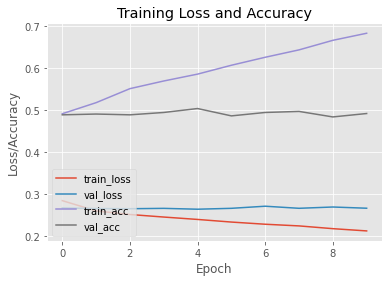

In [48]:
plot_training(history_model_1)

# Evaluate the model

In [49]:
model_1.evaluate(val_dataset)

2/2 [==============================] - 1s 305ms/step - loss: 0.2741 - accuracy: 0.5075


[0.27412375807762146, 0.5074999928474426]

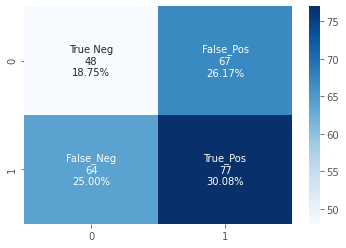

In [51]:
preds, labels = get_model_predictions(val_dataset, model_1)
plot_confusion_matrix(preds, labels)

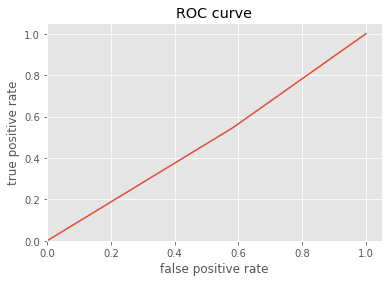

In [52]:
plot_roc_curve(preds, labels)

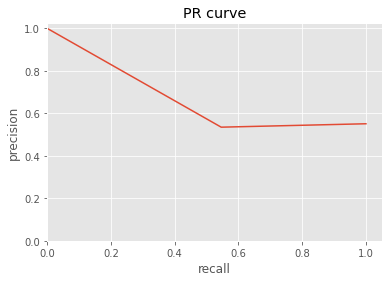

In [53]:
plot_prec_rec_curve(preds, labels)

# EfficientNetB0

In [3]:
img_width = 224
img_height = 224

In [61]:
#Set seed
tf.random.set_seed(42)

base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = keras.layers.Input((img_width, img_height, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation="relu")(x)
outputs = keras.layers.Dense(64, activation="relu")(x)

base_model_2 = keras.models.Model(inputs, outputs)

In [62]:
base_model_2.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1280)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               655872    
_________________________________________________________________
dense_21 (Dense)             (None, 64)                32832     
Total params: 4,738,275
Trainable params: 688,704
Non-trainable params: 4,049,571
_________________________________________________________________


In [63]:
#define inputs and ouputs
img_a = keras.layers.Input((img_width, img_height, 3))
img_b = keras.layers.Input((img_width, img_height, 3))

feat_vect_a = base_model_2(img_a)
feat_vect_b = base_model_2(img_b)

distance = keras.layers.Lambda(euclidean_distance)([feat_vect_a, feat_vect_b])

In [64]:
#Compile the model 
model_2 = keras.models.Model(inputs=[img_a, img_b], outputs=distance)
model_2.compile(loss=contrastive_loss, optimizer="Adam", metrics=["accuracy"])

In [65]:
epochs=10
history_model_2 = model_2.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

Epoch 1/10
32/32 [==============================] - 32s 840ms/step - loss: 0.4723 - accuracy: 0.5000 - val_loss: 0.4183 - val_accuracy: 0.5106
Epoch 2/10
32/32 [==============================] - 25s 795ms/step - loss: 0.3819 - accuracy: 0.4861 - val_loss: 0.3440 - val_accuracy: 0.4975
Epoch 3/10
32/32 [==============================] - 25s 794ms/step - loss: 0.3475 - accuracy: 0.4692 - val_loss: 0.3266 - val_accuracy: 0.4881
Epoch 4/10
32/32 [==============================] - 25s 796ms/step - loss: 0.3320 - accuracy: 0.4699 - val_loss: 0.3180 - val_accuracy: 0.4800
Epoch 5/10
32/32 [==============================] - 25s 796ms/step - loss: 0.3279 - accuracy: 0.4695 - val_loss: 0.3172 - val_accuracy: 0.4856
Epoch 6/10
32/32 [==============================] - 25s 796ms/step - loss: 0.3270 - accuracy: 0.4705 - val_loss: 0.3171 - val_accuracy: 0.4831
Epoch 7/10
32/32 [==============================] - 25s 795ms/step - loss: 0.3263 - accuracy: 0.4696 - val_loss: 0.3162 - val_accuracy: 0.4863

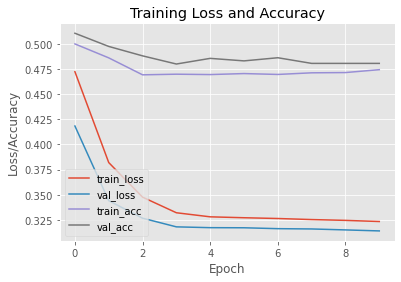

In [66]:
plot_training(history_model_2)

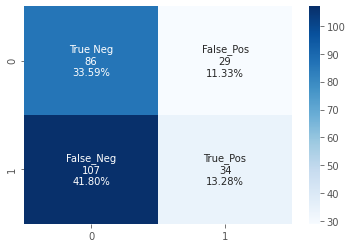

In [67]:
preds, labels = get_model_predictions(val_dataset, model_2)
plot_confusion_matrix(preds, labels)

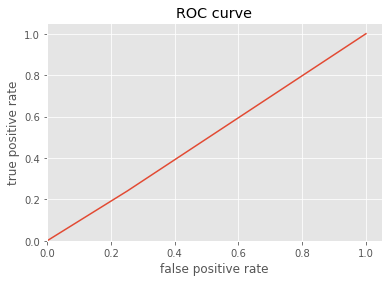

In [68]:
plot_roc_curve(preds, labels)

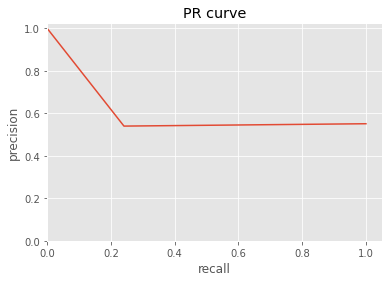

In [69]:
plot_prec_rec_curve(preds, labels)

# VGG 16

In [70]:
img_width = 224
img_height = 224

In [71]:
#Set seed
tf.random.set_seed(42)

base_model = tf.keras.applications.vgg16.VGG16(include_top=False)
base_model.trainable = False

inputs = keras.layers.Input((img_width, img_height, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation="relu")(x)
outputs = keras.layers.Dense(64, activation="relu")(x)

base_model_3 = keras.models.Model(inputs, outputs)

58892288/58889256 [==============================] - 3s 0us/step


In [72]:
base_model_3.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_23 (Dense)             (None, 64)                32832     
Total params: 15,010,176
Trainable params: 295,488
Non-trainable params: 14,714,688
_________________________________________________________________


In [73]:
#define inputs and ouputs
img_a = keras.layers.Input((img_width, img_height, 3))
img_b = keras.layers.Input((img_width, img_height, 3))

feat_vect_a = base_model_3(img_a)
feat_vect_b = base_model_3(img_b)

distance = keras.layers.Lambda(euclidean_distance)([feat_vect_a, feat_vect_b])

In [74]:
#Compile the model 
model_3 = keras.models.Model(inputs=[img_a, img_b], outputs=distance)
model_3.compile(loss=contrastive_loss, optimizer="Adam", metrics=["accuracy"])

In [75]:
epochs=10
history_model_3 = model_3.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

Epoch 1/10
32/32 [==============================] - 53s 1s/step - loss: 0.2754 - accuracy: 0.4674 - val_loss: 0.2690 - val_accuracy: 0.4737
Epoch 2/10
32/32 [==============================] - 31s 978ms/step - loss: 0.2575 - accuracy: 0.5253 - val_loss: 0.2673 - val_accuracy: 0.4806
Epoch 3/10
32/32 [==============================] - 31s 979ms/step - loss: 0.2486 - accuracy: 0.5500 - val_loss: 0.2663 - val_accuracy: 0.4837
Epoch 4/10
32/32 [==============================] - 31s 978ms/step - loss: 0.2421 - accuracy: 0.5683 - val_loss: 0.2655 - val_accuracy: 0.4794
Epoch 5/10
32/32 [==============================] - 31s 979ms/step - loss: 0.2367 - accuracy: 0.5939 - val_loss: 0.2656 - val_accuracy: 0.4787
Epoch 6/10
32/32 [==============================] - 31s 979ms/step - loss: 0.2319 - accuracy: 0.6139 - val_loss: 0.2664 - val_accuracy: 0.4819
Epoch 7/10
32/32 [==============================] - 31s 980ms/step - loss: 0.2281 - accuracy: 0.6281 - val_loss: 0.2667 - val_accuracy: 0.4831
Ep

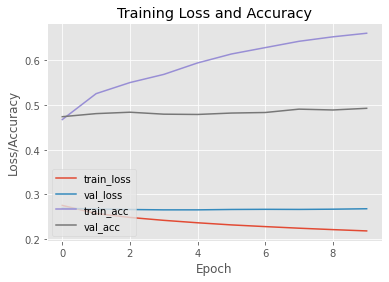

In [95]:
plot_training(history_model_3)

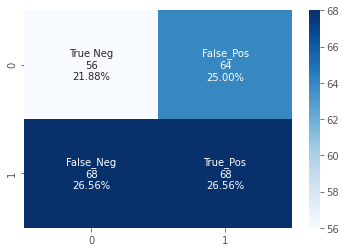

In [104]:
preds, labels = get_model_predictions(val_dataset, model_3)
plot_confusion_matrix(preds, labels)

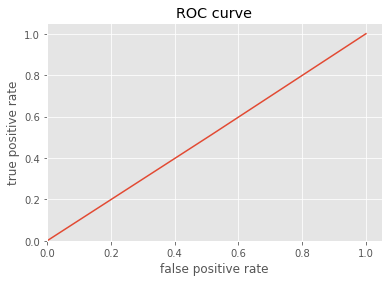

In [97]:
plot_roc_curve(preds, labels)

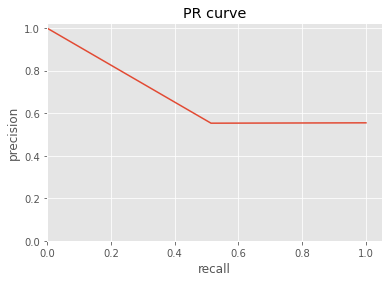

In [98]:
plot_prec_rec_curve(preds, labels)

# Resnet 101 V2

In [82]:
img_width = 224
img_height = 224

In [83]:
#Set seed
tf.random.set_seed(42)

base_model = tf.keras.applications.resnet_v2.ResNet101V2(include_top=False)
base_model.trainable = False

inputs = keras.layers.Input((img_width, img_height, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation="relu")(x)
outputs = keras.layers.Dense(64, activation="relu")(x)

base_model_4 = keras.models.Model(inputs, outputs)

171319296/171317808 [==============================] - 10s 0us/step 


In [84]:
base_model_4.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet101v2 (Functional)     (None, None, None, 2048)  42626560  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 2048)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_25 (Dense)             (None, 64)                32832     
Total params: 43,708,480
Trainable params: 1,081,920
Non-trainable params: 42,626,560
_________________________________________________________________


In [85]:
#define inputs and ouputs
img_a = keras.layers.Input((img_width, img_height, 3))
img_b = keras.layers.Input((img_width, img_height, 3))

feat_vect_a = base_model_4(img_a)
feat_vect_b = base_model_4(img_b)

distance = keras.layers.Lambda(euclidean_distance)([feat_vect_a, feat_vect_b])

In [87]:
#Compile the model 
model_4 = keras.models.Model(inputs=[img_a, img_b], outputs=distance)
model_4.compile(loss=contrastive_loss, optimizer="Adam", metrics=["accuracy"])

In [89]:
epochs=10
history_model_4 = model_4.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

Epoch 1/10
32/32 [==============================] - 45s 1s/step - loss: 0.5655 - accuracy: 0.4807 - val_loss: 0.3289 - val_accuracy: 0.4900
Epoch 2/10
32/32 [==============================] - 35s 1s/step - loss: 0.3130 - accuracy: 0.5139 - val_loss: 0.3267 - val_accuracy: 0.4819
Epoch 3/10
32/32 [==============================] - 35s 1s/step - loss: 0.2892 - accuracy: 0.5443 - val_loss: 0.3387 - val_accuracy: 0.4856
Epoch 4/10
32/32 [==============================] - 35s 1s/step - loss: 0.2800 - accuracy: 0.5690 - val_loss: 0.3302 - val_accuracy: 0.4944
Epoch 5/10
32/32 [==============================] - 35s 1s/step - loss: 0.2489 - accuracy: 0.6125 - val_loss: 0.3492 - val_accuracy: 0.4919
Epoch 6/10
32/32 [==============================] - 35s 1s/step - loss: 0.2447 - accuracy: 0.6201 - val_loss: 0.3251 - val_accuracy: 0.4894
Epoch 7/10
32/32 [==============================] - 35s 1s/step - loss: 0.2461 - accuracy: 0.6252 - val_loss: 0.3343 - val_accuracy: 0.4731
Epoch 8/10
32/32 [==

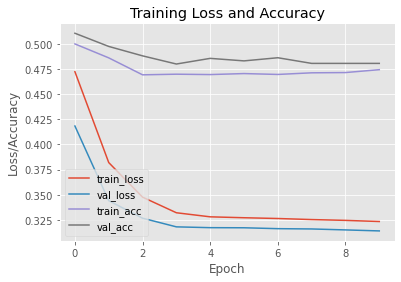

In [90]:
plot_training(history_model_4)

In [110]:
preds, labels = get_model_predictions(val_dataset, model_4)
plot_confusion_matrix(preds, labels)

ValueError: `data` and `annot` must have same shape.

In [ ]:
plot_roc_curve(preds, labels)

In [ ]:
plot_prec_rec_curve(preds, labels)